In [1]:
from pyspark.sql import SparkSession
import time
spark = SparkSession.builder.appName("cs585").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/16 17:29:58 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/16 17:29:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/16 17:29:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/16 17:29:58 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## Reading data (Preparing and saving cleaned data)

In [ ]:
# Reading one tsv file
path = "gs://dataproc-staging-us-central1-51800608968-pazlrfhf/data/amazon_reviews_us_Digital_Video_Games_v1_00.tsv"
# Reading all tsv files in cloud directory
# path = "gs://dataproc-staging-us-central1-51800608968-pazlrfhf/data/"
df = spark.read.options(sep='\t', header=True).csv(path)

In [ ]:
df.createOrReplaceTempView("reviews")

### Exploring data (Preparing and saving cleaned data)

In [ ]:
num_records_raw = df.count()
print("Original # of records:", num_records_raw)
print("Original # of columns:", len(df.columns))
print("Columns:", df.columns)

### Cleaning data (Preparing and saving cleaned data)

In [ ]:
# Getting only the columns we want
columns = ['customer_id', 'review_id', 'product_id', 'product_title', 'product_parent', 'star_rating', 'helpful_votes', 'verified_purchase', 'review_body', 'product_category']
df_unclean = df.select(columns)
df_unclean.createOrReplaceTempView("unclean")

In [ ]:
# Reporting on how many null values columns have -> Run this before the big query to clean out data
from pyspark.sql.functions import col,isnan, when, count
df_unclean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_unclean.columns]).show()

In [ ]:
# Filtering out any record with a null value (doable since the dataset is very clean)
df_reviews = spark.sql("SELECT * FROM unclean WHERE customer_id IS NOT NULL AND review_id IS NOT NULL AND product_id IS NOT NULL AND product_title IS NOT NULL AND product_parent IS NOT NULL AND star_rating IS NOT NULL AND helpful_votes IS NOT NULL AND verified_purchase IS NOT NULL AND review_body IS NOT NULL AND product_category IS NOT NULL")

num_records_clean = df_reviews.count()
print("Number of records after removing null:", num_records_clean)
print("Proportion of dataset remaining:", (num_records_clean / num_records_raw))

In [ ]:
# Save to GC storage
df_reviews.write.options(header=True, delimiter='\t').csv("gs://dataproc-staging-us-central1-51800608968-pazlrfhf/data/reviews_clean.tsv")

### Loading cleaned df in and starting from here

In [2]:
path = "gs://dataproc-staging-us-central1-51800608968-pazlrfhf/data/reviews_clean.tsv"
df_reviews = spark.read.options(sep='\t', header=True).csv(path)

In [3]:
start = time.time()
print(df_reviews.count())
end = time.time()
print("Execution time is",  (end-start), "s")
df_reviews.show(10)

68455608
Execution time is 49.239062786102295 s
+-----------+--------------+----------+--------------------+--------------+-----------+-------------+-----------------+--------------------+----------------+
|customer_id|     review_id|product_id|       product_title|product_parent|star_rating|helpful_votes|verified_purchase|         review_body|product_category|
+-----------+--------------+----------+--------------------+--------------+-----------+-------------+-----------------+--------------------+----------------+
|   39047498|R153FQBHVDEIC8|0790731509|      Cool Hand Luke|     384800290|          5|            1|                N|There's a line in...|       Video DVD|
|   13401693|R2S99ZUJ8FBMA2|0385336810|Can You Keep a Se...|     693014192|          5|            2|                N|This book was one...|           Books|
|   25340265|R1CI4U8F7H8RWU|B00097DX3U|        Out Of Exile|     248256324|          4|            1|                N|I have been looki...|           Music|
|   

In [4]:
df_reviews.createOrReplaceTempView("reviews")

### Visualizing Data

Execution time is 223.52385234832764 s


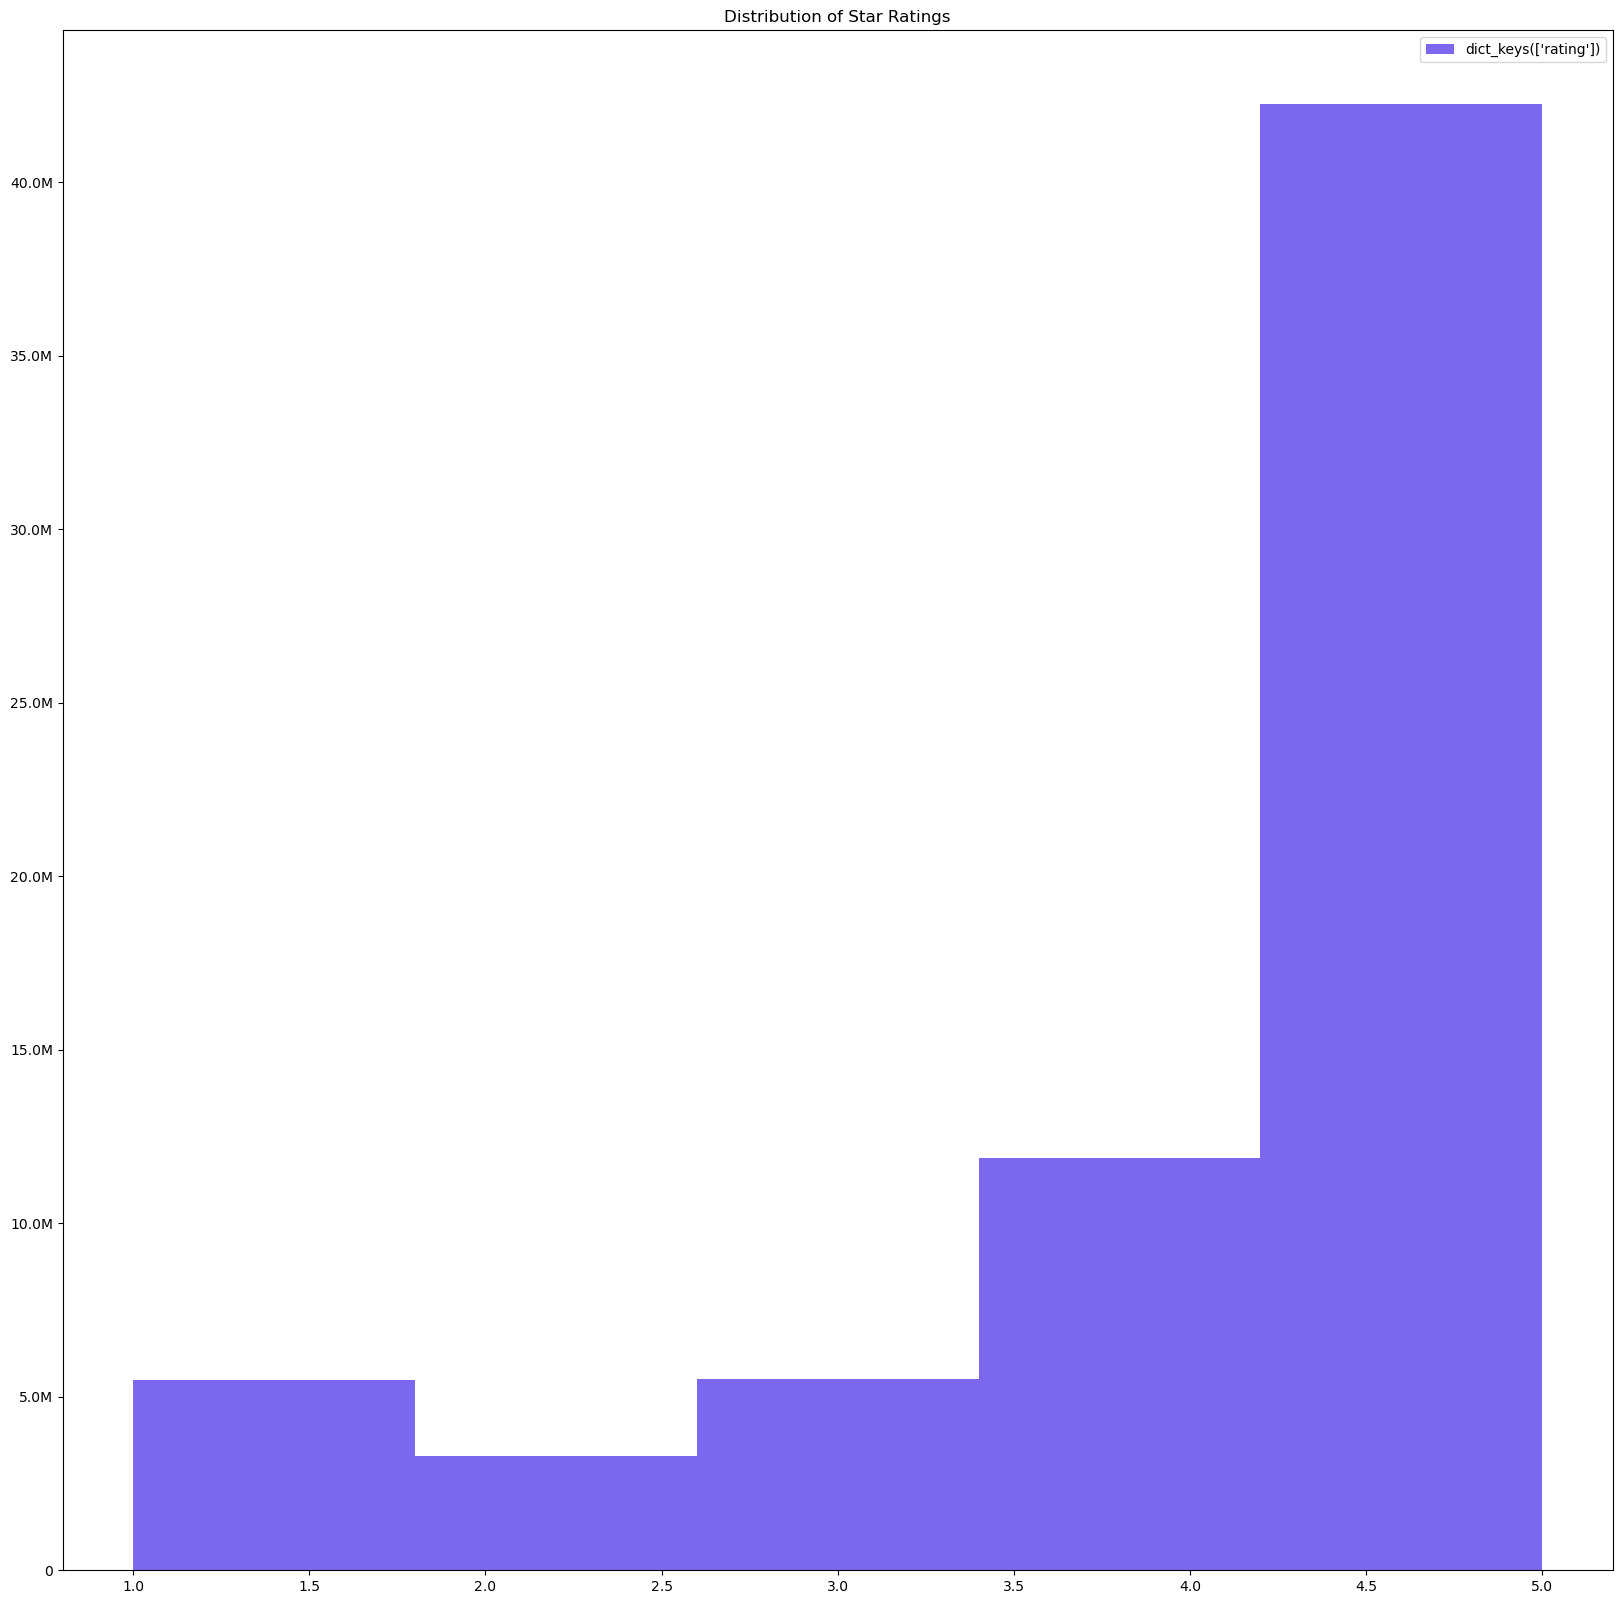

In [7]:
import time
# Visualizations for data
from pyspark_dist_explore import Histogram, hist, distplot
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
start = time.time()
cols = ['star_rating']
df_plot_stars = df_reviews.select(col("star_rating").cast('int').alias("rating"))
# df_plot_stars.show(10)

# Create the plots
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 20)

# Use the hist function to plot histograms on the Axes
hist(axes, [df_plot_stars], bins = 5, color=['mediumslateblue'])
axes.set_title('Distribution of Star Ratings')
axes.legend()
end = time.time()
print("Execution time is",  (end-start), "s")

### Queries for presentation (using df for small sample, change to df_reviews)

In [12]:
import time

In [8]:
# 1 - What are the most active customers like?
# Aggregate by customer_id, get count of reviews
customers = spark.sql("SELECT customer_id as customer, avg(star_rating) as avg_rating, count(review_body) as reviews_given, sum(helpful_votes) as helpful_votes FROM reviews GROUP BY customer_id ORDER BY reviews_given DESC")
customers.createOrReplaceTempView("customers")
start = time.time()
customers.show(20)
end = time.time()
print("Execution time is",  (end-start), "s")

+--------+------------------+-------------+-------------+
|customer|        avg_rating|reviews_given|helpful_votes|
+--------+------------------+-------------+-------------+
|50122160| 4.998050163963485|        22566|     136660.0|
|50732546|4.6818716892289585|        10194|      59193.0|
|50736950|3.9987240459343463|         8621|      16922.0|
|51184997|  4.14562260202302|         5734|      31378.0|
|38214553|  4.13078178849991|         5513|      14067.0|
|52496677| 4.714816262705239|         5116|      38899.0|
|18116317| 4.115472958864063|         4789|       9469.0|
|23267387|3.9291878734233237|         4519|      12587.0|
|50345651|  4.97923875432526|         4046|      28508.0|
|50881246| 4.108548508398095|         3989|      51619.0|
|14539589| 4.968229166666666|         3840|       1451.0|
|22073263| 4.784875784875785|         3663|      29958.0|
| 7080939|               5.0|         3585|        115.0|
|20018062| 4.880492091388401|         3414|      11562.0|
|50199793| 4.7

In [22]:
# Let's check out customer 50122160
temp_cust = spark.sql("SELECT customer_id, product_title, star_rating, review_body, product_category FROM reviews WHERE customer_id == 50122160")
temp_cust.show(20)
temp_cust.createOrReplaceTempView("tempCust")

by_categories = spark.sql("SELECT product_category, count(review_body) as num_reviews FROM tempCust GROUP BY product_category")
by_categories.show(20)

+-----------+--------------------+-----------+--------------------+----------------+
|customer_id|       product_title|star_rating|         review_body|product_category|
+-----------+--------------------+-----------+--------------------+----------------+
|   50122160|Century Rain (Rev...|          5|Alastair Reynolds...|           Books|
|   50122160|Blue Ocean Strate...|          5|W. Chan Kim and R...|           Books|
|   50122160|         The Shining|          5|Stephen King's Th...|           Books|
|   50122160|Speaker for the Dead|          5|Orson Scott Card'...|           Books|
|   50122160|A Million Little ...|          5|James Frey entere...|           Books|
|   50122160|The Game: Penetra...|          5|Two years ago aut...|           Books|
|   50122160|The Game: Penetra...|          5|Two years ago aut...|           Books|
|   50122160|The Game: Penetra...|          5|Two years ago aut...|           Books|
|   50122160|       Haunted House|          5|Ages 3 and older ..

+--------------------+-----------+
|    product_category|num_reviews|
+--------------------+-----------+
|               Video|          2|
|Digital_Video_Dow...|          1|
|Digital_Ebook_Pur...|         27|
|           Video DVD|          7|
|               Books|      22105|
|               Music|        409|
|     Office Products|          1|
|Digital_Music_Pur...|         14|
+--------------------+-----------+



In [9]:
# 2 - What are the most reviewed products like?
# Aggregate by product_parent, get count of products reviewed and avg review
products = spark.sql("SELECT product_parent, product_title, product_category, avg(star_rating) as avg_rating, count(review_body) as num_reviews FROM reviews GROUP BY product_parent, product_title, product_category ORDER BY num_reviews DESC")
products.createOrReplaceTempView("products")
start = time.time()
products.show(10)
end = time.time()
print("Execution time is",  (end-start), "s")

+--------------+--------------------+--------------------+-----------------+-----------+
|product_parent|       product_title|    product_category|       avg_rating|num_reviews|
+--------------+--------------------+--------------------+-----------------+-----------+
|      46324555|    Candy Crush Saga|         Mobile_Apps|4.404351387529219|     100106|
|     488246640|The Secret Societ...|         Mobile_Apps|4.086244091625257|      82510|
|       9632738|           Minecraft|         Mobile_Apps|4.542465987362669|      70266|
|     879319057|      Subway Surfers|         Mobile_Apps|4.661232948745708|      64658|
|     828652896|         Crossy Road|         Mobile_Apps|4.776457614456974|      56222|
|     265040255|            My Horse|         Mobile_Apps|4.631020014110133|      53862|
|     853694223|      Bosch Season 1|Digital_Video_Dow...|4.606098799804357|      53158|
|     271429756|Minion Rush: Desp...|         Mobile_Apps| 4.46026180458158|      51336|
|     846062547|     

In [10]:
# 3 - How does average star rating compare globally, within each category, within each product, and for the most active customers?

# Globally
global_avg = spark.sql("SELECT avg(star_rating) as global_avg FROM reviews")
start = time.time()
global_avg.show(1)
end = time.time()
print("Execution time is",  (end-start), "s")

# Within each category 
categories = spark.sql("SELECT product_category, avg(star_rating) as avg_rating, count(review_body) as num_reviews FROM reviews GROUP BY product_category ORDER BY avg_rating DESC")
categories.createOrReplaceTempView("categories")
start = time.time()
categories.show(30)
end = time.time()
print("Execution time is",  (end-start), "s")

+----------------+
|      global_avg|
+----------------+
|4.19998503263604|
+----------------+

Execution time is 68.6907651424408 s


+--------------------+------------------+-----------+
|    product_category|        avg_rating|num_reviews|
+--------------------+------------------+-----------+
|           Gift Card| 4.731352294070298|     149080|
|Digital_Music_Pur...| 4.638545317307992|    1796487|
|Personal_Care_App...| 4.555555555555555|          9|
|                Toys| 4.453286478439248|      57767|
|               Music| 4.435092626650276|    5529834|
|            Software|  4.39622641509434|         53|
|           Video DVD|  4.36165694737725|    1096788|
|               Tools| 4.348335552596538|       7510|
|             Grocery| 4.312264985461516|    2402245|
|               Shoes| 4.295814709467696|       7383|
|Digital_Ebook_Pur...| 4.262513826040071|    6350336|
| Musical Instruments|  4.25850588342607|      10963|
|          Automotive| 4.246274269216684|    3514277|
|               Video|4.2412715401905166|      46715|
|            Outdoors| 4.239967241743527|    2305373|
|             Watches|  4.23

In [11]:
# Within each category 
categories = spark.sql("SELECT product_category, avg(star_rating) as avg_rating, count(review_body) as num_reviews FROM reviews GROUP BY product_category ORDER BY avg_rating ASC")
categories.createOrReplaceTempView("categories")
start = time.time()
categories.show(10)
end = time.time()
print("Execution time is",  (end-start), "s")

+-------------------+------------------+-----------+
|   product_category|        avg_rating|num_reviews|
+-------------------+------------------+-----------+
|   Digital_Software| 3.539401242187347|     102078|
|   Major Appliances| 3.716363223515812|      96888|
|Digital_Video_Games|3.8531407942238265|     145425|
|            Kitchen|3.9934888768312535|       1843|
|           Wireless| 4.031896665348623|      22761|
|        Mobile_Apps| 4.033716673973296|    6507786|
|        Electronics| 4.035706384046277|    3105130|
| Home Entertainment| 4.036964021685559|      36522|
|               Home| 4.052316890881913|       2007|
|            Luggage| 4.064102564102564|         78|
+-------------------+------------------+-----------+
only showing top 10 rows

Execution time is 73.91969108581543 s


In [23]:
# 4 - How do most helpful viewers compare?
most_helpful = spark.sql("SELECT * FROM customers ORDER BY helpful_votes DESC")
start = time.time()
most_helpful.show(10)
end = time.time()
print("Execution time is",  (end-start), "s")

+--------+----------+-------------+-------------+
|customer|avg_rating|reviews_given|helpful_votes|
+--------+----------+-------------+-------------+
|26834793|       1.0|            1|       5068.0|
|37248460|       1.0|            1|       3789.0|
|50432755|       5.0|            1|       2509.0|
|44692602|       5.0|            1|       2384.0|
|26458957|       1.0|            1|       1823.0|
|13560072|       1.0|            1|       1139.0|
|29805145|       1.0|            1|       1100.0|
|12708262|       5.0|            1|        993.0|
|34790787|       5.0|            1|        882.0|
|52990130|       1.0|            1|        685.0|
+--------+----------+-------------+-------------+
only showing top 10 rows



### Shuffle data and take a sample for ML

In [31]:
# Showing first 10 samples normally
df_reviews.show(10)

+-----------+--------------+----------+--------------------+--------------+-----------+-------------+-----------------+--------------------+-------------------+
|customer_id|     review_id|product_id|       product_title|product_parent|star_rating|helpful_votes|verified_purchase|         review_body|   product_category|
+-----------+--------------+----------+--------------------+--------------+-----------+-------------+-----------------+--------------------+-------------------+
|   21269168| RSH1OZ87OYK92|B013PURRZW|Madden NFL 16 - X...|     603406193|          2|            2|                N|I keep buying mad...|Digital_Video_Games|
|     133437|R1WFOQ3N9BO65I|B00F4CEHNK| Xbox Live Gift Card|     341969535|          5|            0|                Y|             Awesome|Digital_Video_Games|
|   45765011| R3YOOS71KM5M9|B00DNHLFQA|Command & Conquer...|     951665344|          5|            0|                Y|If you are preppi...|Digital_Video_Games|
|     113118|R3R14UATT3OUFU|B004RM

In [32]:
# Randomly shuffle first
df_sample = df_reviews.sample(fraction=0.1, seed=1000) # Seed saves the random instance, fraction is proportion of dataset
print("Number of records:", df_sample.count())
df_sample.show(10)

Number of records: 14484
+-----------+--------------+----------+--------------------+--------------+-----------+-------------+-----------------+--------------------+-------------------+
|customer_id|     review_id|product_id|       product_title|product_parent|star_rating|helpful_votes|verified_purchase|         review_body|   product_category|
+-----------+--------------+----------+--------------------+--------------+-----------+-------------+-----------------+--------------------+-------------------+
|   21269168| RSH1OZ87OYK92|B013PURRZW|Madden NFL 16 - X...|     603406193|          2|            2|                N|I keep buying mad...|Digital_Video_Games|
|   38426028|R1LRYU1V0T3O38|B00S00IJH8|              Sims 4|     215163395|          4|            0|                Y|i like the new sk...|Digital_Video_Games|
|   26540306|R1JEEW4C6R89BA|B00K59HKIQ|Playstation Netwo...|     384246568|          5|            0|                Y|                  Ok|Digital_Video_Games|
|   22151

### Analyzing review_body - Sentiment analysis

In [8]:
# Getting packages needed for textual analysis
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

In [22]:
# Defining a function to preprocess the text in review_body
def preprocess_body(text):
    processed = text
    processed.replace('[^\w\s]', '')
    processed = " ".join(word for word in processed.split() if word not in stop_words)
    return processed

def extract_polarity(text):
    processed = preprocess_body(text)
    polarity = TextBlob(processed).sentiment[0]
    return polarity
    
# test_good = "I love this game, it's so amazing and perfect!"
# test_bad = "I hate this game, it's terrible, and broken and stinks!"
# print(extract_polarity(test_good))
# print(extract_polarity(test_bad))

In [23]:
# Trying to get a UDF working on the set of 100,000+ records
# Converting extract_polarity function to a UDF
# polarityUDF = udf(lambda t: extract_polarity(t))

# Using UDF on the dataframe
spark.udf.register("polarityUDF", extract_polarity)
temp = spark.sql("SELECT product_parent, review_body, polarityUDF(review_body) as polarity FROM reviews")
temp.show(20)

22/12/08 21:57:54 WARN org.apache.spark.sql.catalyst.analysis.SimpleFunctionRegistry: The function polarityudf replaced a previously registered function.


+--------------+--------------------+--------+
|product_parent|         review_body|polarity|
+--------------+--------------------+--------+
|     603406193|I keep buying mad...|     932|
|     341969535|             Awesome|       7|
|     951665344|If you are preppi...|     163|
|     395682204|             Perfect|       7|
|     640460561|            Awesome!|       8|
|     621922192|            Awesome!|       8|
|     215163395|i like the new sk...|     106|
|     384246568|               Super|       5|
|     384246568|Excellent, fast a...|      29|
|     384246568|                  Ok|       2|
|     151985175|As has been writt...|     540|
|     695277014|Probably the best...|     434|
|     112160022|            Awesome!|       8|
|     835376637|COOL BUT IT LAGES...|      34|
|     112160022|Lames purchase I ...|      37|
|     384246568|               Great|       5|
|     395682204|          Awesome!!!|      10|
|     552981447|pretty good but n...|      86|
|     2328037

### Experimenting with product aggregation

In [27]:
# Aggregating by product, sorting by number of reviews per product
products = spark.sql("SELECT product_parent as parent, product_title as parent_name, avg(star_rating) as avg_rating, count(star_rating) as num_reviews FROM reviews GROUP BY product_parent, product_title ORDER BY num_reviews DESC")
products.show(10) # Showing top 10 most reviewed
products.createOrReplaceTempView("products")

# How many products?
print("How many products are there?", products.count())

+---------+--------------------+------------------+-----------+
|   parent|         parent_name|        avg_rating|num_reviews|
+---------+--------------------+------------------+-----------+
|384246568|Playstation Netwo...|  4.67797976836241|      13642|
|232803743|Xbox Live Subscri...| 4.654988367319009|       7307|
|395682204|Playstation Plus ...| 4.684556094775906|       3503|
|341969535| Xbox Live Gift Card| 4.542466550319953|       3438|
|402222185|SimCity - Limited...|1.7065351418002466|       3244|
|225309182|Xbox 360 Live Poi...|4.5810276679841895|       3036|
| 53534661|Playstation Plus ...| 4.583953680727874|       1209|
|240448759|       Battlefield 4| 3.308890925756187|       1091|
|954148166|Final Fantasy XIV...|3.7673684210526317|        950|
|912779847|Command and Conqu...|3.4365714285714284|        875|
+---------+--------------------+------------------+-----------+
only showing top 10 rows

How many products are there? 7767


In [25]:
# Trying to see if each parent maps to the same product title

# Find products with a viewable number of reviews (start with 5)
products_sample = spark.sql("SELECT parent, avg_rating, num_reviews FROM products WHERE num_reviews == 5")
products_sample.show(10)

# Let's use parent # 895422770
this_parent = spark.sql("SELECT product_parent, star_rating, product_title, product_category, review_body FROM reviews WHERE product_parent == 895422770")
this_parent.show(5) # There are only 5 anyways

# Hypothesis confirmed, they do have the same product_title

+---------+----------+-----------+
|   parent|avg_rating|num_reviews|
+---------+----------+-----------+
|759226930|       4.0|          5|
|895422770|       4.8|          5|
|317322202|       3.6|          5|
|644765406|       2.8|          5|
|989895479|       2.4|          5|
|  3780849|       4.4|          5|
|642098572|       3.2|          5|
|905725513|       5.0|          5|
|198829755|       4.2|          5|
|889729196|       4.2|          5|
+---------+----------+-----------+
only showing top 10 rows



+--------------+-----------+--------------------+-------------------+--------------------+
|product_parent|star_rating|       product_title|   product_category|         review_body|
+--------------+-----------+--------------------+-------------------+--------------------+
|     895422770|          5|Mass Effect 3 Dig...|Digital_Video_Games|Mass Effect 3 is ...|
|     895422770|          4|Mass Effect 3 Dig...|Digital_Video_Games|As the title says...|
|     895422770|          5|Mass Effect 3 Dig...|Digital_Video_Games|To tell the truth...|
|     895422770|          5|Mass Effect 3 Dig...|Digital_Video_Games|Well I can Instan...|
|     895422770|          5|Mass Effect 3 Dig...|Digital_Video_Games|Played it and bea...|
+--------------+-----------+--------------------+-------------------+--------------------+



### Data cleaning prep - analyzing columns

In [41]:
# Looking into products that only have 1 review to see if they're unideal
one_review = spark.sql("SELECT parent, avg_rating, num_reviews FROM products WHERE num_reviews == 1")
print("Number of products with 1 review:", one_review.count())
one_review.createOrReplaceTempView("onereview")

# Joining this with reviews to see the other (non-aggregate) fields
one_review_full = spark.sql("SELECT parent, product_title, star_rating, review_body, product_category FROM onereview JOIN reviews ON onereview.parent == reviews.product_parent")
one_review_full.show(50)

# My conclusion is that they seem normal, I was wrong

Number of products with 1 review: 2026


+---------+--------------------+-----------+--------------------+-------------------+
|   parent|       product_title|star_rating|         review_body|   product_category|
+---------+--------------------+-----------+--------------------+-------------------+
|640460561|Saints Row IV - E...|          5|            Awesome!|Digital_Video_Games|
|186027895|Nat Geo Adventure...|          5|      Fun to replay.|Digital_Video_Games|
|955513685|Gears of War Judg...|          5|Love it! Just hea...|Digital_Video_Games|
|529343665|    Scrub [Download]|          1|Horrible game, ho...|Digital_Video_Games|
| 43400224|Midnight Club Los...|          4|          Great game|Digital_Video_Games|
|102588464|Batman: Arkham Kn...|          5|If you're a fan o...|Digital_Video_Games|
|  1879635|  Grand Theft Auto V|          1|Game barely loads...|Digital_Video_Games|
|947161997|Megaman Legacy Co...|          5|What is Mega Man?...|Digital_Video_Games|
|726802862|Grand Theft Auto ...|          5|WORKED jus